# Acquisition & Comparison of AQI Data

This scipt is to compare our annual smoke estimates of Farmington, NM with the EPA's Air Quality Index (AQI).
This script contains code that has been either modified or directly used from the [sample code for accessing the US EPA Air Quality System API](https://drive.google.com/file/d/1bxl9qrb_52RocKNGfbZ5znHVqFDMkUzf/view) notebook, originally created by Professor McDonald. This notebook is an educational resource for the "DATA 512" course, part of the University of Washington's Master of Science in Data Science program. It is important to acknowledge that this code is made available under the [Creative Commons CC-BY license](https://creativecommons.org/licenses/by/4.0/), with a revision date of August 13, 2023 (Revision 1.0).

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import json, time
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Reading in the annual smoke estimate
ase = pd.read_csv('C:/Users/adith/Documents/data-512-common-analysis/intermediate/annual_smoke_estimate.csv')

We will now initialise constants required to call the AQI API

In [4]:
USERNAME = 'YOUREMAIL@gmail.com'
APIKEY = 'YOURKEY'

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

If it is your first time using the AQI API/lost the API Key,then you will have to sign up using the code block below. Please uncomment if necessary.

In [5]:
'''#Request email
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

print("Requesting SIGNUP ...")
response = request_signup("ekrolen@uw.edu")
print(json.dumps(response,indent=4))'''

'#Request email\ndef request_signup(email_address = None,\n                   endpoint_url = API_REQUEST_URL, \n                   endpoint_action = API_ACTION_SIGNUP, \n                   request_template = AQS_REQUEST_TEMPLATE,\n                   headers = None):\n    \n    # Make sure we have a string - if you don\'t have access to this email addres, things might go badly for you\n    if email_address:\n        request_template[\'email\'] = email_address        \n    if not request_template[\'email\']: \n        raise Exception("Must supply an email address to call \'request_signup()\'")\n    \n    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request\n    request_url = endpoint_url+endpoint_action.format(**request_template)\n        \n    # make the request\n    try:\n        # Wait first, to make sure we don\'t exceed a rate limit in the situation where an exception occurs\n        # during the request processing - throt

The next function called request_list_info, is used to make a list request to the API. It allows you to retrieve information about groups or parameter class descriptors related to AI. The function takes parameters such as email_address and key for authentication, and it constructs a request to the API endpoint using these parameters. If successful, it returns the response in JSON format.

In [6]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

The next code snippet is used to retrieve information about different sensor classes, which are custom names for clusters of sensors in an air quality sensing system. These classes help identify specific sensors. The code sets up a request using predefined template data, including an email and API key, and then sends the request to retrieve sensor information.

In [7]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

We're interested in obtaining Air Quality Index (AQI) measurements, so we should choose sensors specifically designed to measure AQI. Based on the information provided earlier, we will utilize the sensor group named "AQI POLLUTANTS" to obtain the IDs of individual sensors responsible for AQI measurements.

In [8]:
AQI_PARAM_CLASS = "AQI POLLUTANTS"

#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


With the information provided in the output above, we can determine the sensor codes associated with each element of AQI. The AQI encompasses both gases and particulates in its measurements, and the respective codes for these components are listed below. To comply with API limitations regarding the number of codes that can be included in the request, we need to separate the sensors into two groups.

In [9]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

Define the details of Farmington, NM. The FIPS for this location can be obtained from [this list](https://www.census.gov/library/reference/code-lists/ansi.html).

In [10]:
CITY_LOCATIONS = {
    'farmington' :       {'city'   : 'Farmington',
                       'county' : 'San Juan',
                       'state'  : 'New Mexico',
                       'fips'   : '35045', #Combination of state (35) and county (045) FIPS codes
                       'latlon' : [36.755556, -108.182222]}, 
}

Now let us get the list of EPA Monitoring sites within Farmington.

In [11]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['farmington']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['farmington']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": null
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": "SITE LOCATED ON MESA TOP WITHIN MUNICIPAL AIRPORT"
    },
    {
        "code": "0009",
        "value_represented": "1ZB Bloomfield"
    },
    {
        "code": "0010",
        "value_represented": null
    },
    {
        "code": "0011",
        "value_represented": null
    },
    {
        "code": "0012",
        "value_represented": null
    },
    {
        "code": "0013",
        "value_represented": null
    },
    {
        "c

We can see that there are stations within the San Juan county. We will proceed to get the AQI values from these stations. To achieve this, we make daily summary requests. Since we have stations, we will not go with the bounding technique to get AQI values.

In [12]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [13]:
#Setting up requests
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['farmington']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['farmington']['fips'][2:]

The next chunk retrieves daily summaries of AQIelements from local sensors near Farmington. The data collection will occur only for the fire season, which aligns with the need to compare it with wildland fire smoke estimates. The fire season typically runs from May 1st to October 31st when most wildfires occur.

Furthermore, while some stations may provide detailed AQI measurements on an hourly basis, the AQI calculation relies on daily air quality summaries, specifically daily maximums or daily averages. Using shorter-term data, such as hourly readings, to calculate AQI values is not considered valid according to the [Technical Assistance Document for the Reporting of Daily Air Quality](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf).

As a result, we intend to utilize the 24-Hour Block Average (24-HR BLK AVG) AQI measurement for each gas or particulate component.

In [14]:
# Function to append the collected AQI data
def append_aqi_data(df, aqi_data):
    
    # Loop through each record in the 'Data' part of the response
    for i in aqi_data['Data']:
        
        # Check for '24-HR BLK AVG' duration
        if i['sample_duration'] == '24-HR BLK AVG':
            
            # Append to DataFrame
            df = df.append({
                'site_number': i['site_number'],
                'parameter_code': i['parameter_code'],
                'sample_duration': i['sample_duration'],
                'date_local': i['date_local'],
                'aqi':i['aqi']}, ignore_index = True)
    return df

In [16]:
# Initialize an empty DataFrame for the AQI data
AQI_df = pd.DataFrame(columns=['site_number', 'parameter_code', 'sample_duration', 'date_local', 'aqi'])

# Loop through the years and request data
for year in range(1963, 2024):
    print(f"Processing AQI data for {year}...")
    begin_date = f"{year}0501"  # May 1st of the given year
    end_date = f"{year}1031"    # October 31st of the given year

    # Request gaseous data
    request_data['param'] = AQI_PARAMS_GASEOUS
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
    if gaseous_aqi and gaseous_aqi["Header"][0]['status'] == "Success":
        # Extract and append data
        AQI_df = append_aqi_data(AQI_df, gaseous_aqi)

    # Request particulate data
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
    if particulate_aqi and particulate_aqi["Header"][0]['status'] == "Success":
        # Extract and append data
        AQI_df = append_aqi_data(AQI_df, particulate_aqi)

    # Save intermediate outputs if needed, for example, every 5 years
    if (year - 1963) % 5 == 0:
        AQI_df.to_csv("C:/Users/adith/Documents/data-512-common-analysis/intermediate/daily_aqi.csv", index=False)

# Save final DataFrame to .csv file
AQI_df.to_csv("C:/Users/adith/Documents/data-512-common-analysis/intermediate/daily_aqi.csv", index=False)


Processing AQI data for 1963...
Processing AQI data for 1964...
Processing AQI data for 1965...
Processing AQI data for 1966...
Processing AQI data for 1967...
Processing AQI data for 1968...
Processing AQI data for 1969...
Processing AQI data for 1970...
Processing AQI data for 1971...
Processing AQI data for 1972...
Processing AQI data for 1973...
Processing AQI data for 1974...
Processing AQI data for 1975...
Processing AQI data for 1976...
Processing AQI data for 1977...
Processing AQI data for 1978...
Processing AQI data for 1979...
Processing AQI data for 1980...
Processing AQI data for 1981...
Processing AQI data for 1982...
Processing AQI data for 1983...
Processing AQI data for 1984...
Processing AQI data for 1985...
Processing AQI data for 1986...
Processing AQI data for 1987...
Processing AQI data for 1988...
Processing AQI data for 1989...
Processing AQI data for 1990...
Processing AQI data for 1991...
Processing AQI data for 1992...
Processing AQI data for 1993...
Processi

In [4]:
AQI_df = pd.read_csv('C:/Users/adith/Documents/data-512-common-analysis/intermediate/daily_aqi.csv')

print(f"The stations which return AQI information are: {AQI_df['site_number'].unique()}")
print(f"The pollutants returned are: {AQI_df['parameter_code'].unique()}")

print(AQI_df.head())

The stations which return AQI information are: [  13   14   15   16 1005   17    8    9   18 1233]
The pollutants returned are: [42401 88502 81102]
   site_number  parameter_code sample_duration  date_local  aqi
0           13           42401   24-HR BLK AVG  1974-05-08  NaN
1           13           42401   24-HR BLK AVG  1974-05-09  NaN
2           13           42401   24-HR BLK AVG  1974-05-10  NaN
3           13           42401   24-HR BLK AVG  1974-05-11  NaN
4           13           42401   24-HR BLK AVG  1974-05-12  NaN


As seen from the output above, stations report more than one type of particulate matter, it is necessary to determine the maximum particulate AQI per station. Then, we will proceed to calculate the annual average AQI for the stations. This calculation involves averaging the AQI values across all stations to get it to the annual level. 

In [38]:
# Get the maximum AQI per station as we have >1 particulate matter
AQI_df = AQI_df.groupby(['site_number', 'date_local'])['aqi'].max().reset_index()

# Getting Year as a column
AQI_df['year'] = AQI_df['date_local'].str[:4]

# Group by year and get the average the AQI
yearly_avg_AQI = AQI_df.groupby('year')['aqi'].mean().to_frame('yearly_avg_aqi').reset_index()

# Save this as the final AQI csv file
yearly_avg_AQI.to_csv('C:/Users/adith/Documents/data-512-common-analysis/intermediate/yearly_aqi.csv', index = None)

## Compating Smoke Estimate with AQI

In [39]:
# Load the smoke estimates and AQI data
smoke = pd.read_csv('C:/Users/adith/Documents/data-512-common-analysis/intermediate/annual_smoke_estimate.csv')
aqi = pd.read_csv('C:/Users/adith/Documents/data-512-common-analysis/intermediate/yearly_aqi.csv')

In [40]:
# Combine them to make comparisons
smoke_aqi = pd.merge(left = smoke, right = aqi, how = "inner", left_on = 'FireYear', right_on = 'year')
smoke_aqi = smoke_aqi.dropna()
smoke_aqi

,FireYear,SmokeEstimate,year,yearly_avg_aqi
30,2005,6.838876,2005,9.185185
31,2006,7.244551,2006,9.873418
32,2007,7.733844,2007,21.757746
33,2008,4.943591,2008,18.167665
34,2009,3.968015,2009,16.940439
35,2010,2.811523,2010,17.211806
36,2011,9.525030,2011,17.618497
37,2012,8.075237,2012,21.313916
38,2013,4.750725,2013,15.459184
39,2014,3.727003,2014,12.846154


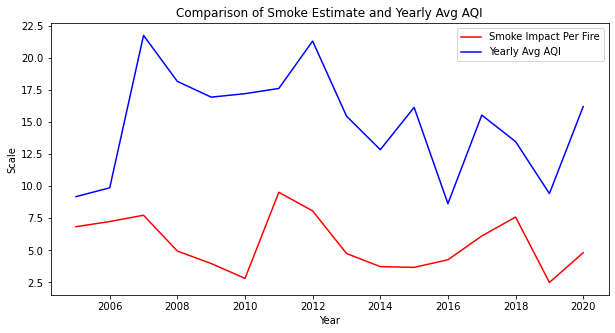

In [42]:
# Create the plot
plt.figure(figsize=(10, 5))

# Plot SmokeImpactPerFire
plt.plot(df.index, df['SmokeEstimate'], label='Smoke Impact Per Fire', color='red')

# Plot yearly_avg_aqi
plt.plot(df.index, df['yearly_avg_aqi'], label='Yearly Avg AQI', color='blue')

# Create labels, title, and show legend
plt.xlabel('Year')
plt.ylabel('Scale')
plt.title('Comparison of Smoke Estimate and Yearly Avg AQI')
plt.legend()

# Show the plot
plt.show()

## Observation from Comparison

- Trends and Patterns: Both the Smoke Impact Per Fire and Yearly Avg AQI seem to follow a generally similar pattern, with rises and falls occurring around the same periods. However, they do not appear to be directly proportional; that is, high spikes in smoke impact do not necessarily correspond to equivalent spikes in AQI.

- Volatility: The Yearly Avg AQI shows more variability than Smoke Impact Per Fire, with more pronounced peaks and troughs. This could indicate that the AQI is influenced by a wider range of factors, possibly including other pollution sources, weather conditions, or regulatory changes over the years.

- Relationship: There doesn’t seem to be a clear one-to-one relationship between the two variables, indicating that while wildfires and the resulting smoke may contribute to AQI, they are likely not the sole determinant. Other environmental and human factors likely play significant roles.

- Data Distribution: Both data series have fluctuations, but neither shows a clear long-term upward or downward trend within this time frame. The lack of a trend could imply that while annual variations occur, there hasn't been a sustained increase or decrease in either measure over these years.

- Anomalies: There are certain years where the AQI peaks significantly — for example, around 2007 and 2012. It would be worth investigating what specific events or conditions caused these peaks, such as an increase in fire severity, frequency, or other environmental conditions.

- Future Work: It's crucial to keep in mind that our smoke estimation is quite basic and doesn't account for significant variables. While there is a slight observed pattern, the recommended approach is to experiment with the Smoke Estimate and explore ways to establish a stronger correlation between the two metrics.